# VAS Ratings Analysis
This notebook analyzes VAS ratings from the experiment CSV files, summarizes them, computes statistics, and visualizes the results.

## 1. Import Required Libraries
Import pandas, numpy, and matplotlib for data analysis and visualization.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

## 2. Load and Combine Experiment CSV Files
Load all relevant CSV files and combine the VAS ratings into a single DataFrame.

In [4]:
# Load all CSV files and extract VAS ratings (OPTIMIZED - only load needed columns)
csv_files = glob.glob('./Data/*.csv')
print(f'Found {len(csv_files)} CSV files. Loading VAS ratings...')
vas_frames = []

for i, file in enumerate(csv_files):
    if (i + 1) % 10 == 0:
        print(f'  Processing file {i+1}/{len(csv_files)}...')
    
    try:
        # First, peek at column names without loading full file
        with open(file, 'r', encoding='utf-8') as f:
            header = f.readline().strip().split(',')
        
        # Determine which column to load
        if 'slider.rating' in header:
            vas_col = 'slider.rating'
        elif 'slider.response' in header:
            vas_col = 'slider.response'
        else:
            vas_cols = [col for col in header if 'VAS' in col or 'ratingScenarioLoop.slider.rt' in col or 'response' in col]
            vas_col = vas_cols[0] if len(vas_cols) > 0 else None
        
        if vas_col is not None:
            # Only load the specific column we need (MUCH faster)
            df = pd.read_csv(file, encoding='utf-8', usecols=[vas_col], on_bad_lines='skip')
            df['file'] = file
            vas_frames.append(df)
    except Exception as e:
        print(f'  Warning: Could not process {file}: {e}')
        continue

vas_df = pd.concat(vas_frames, ignore_index=True)
print(f'\n✓ Combined VAS ratings from {len(csv_files)} files.')
print(f'Total rows: {len(vas_df)}')
print('\nFirst overview:')
print(vas_df.head())

Found 141 CSV files. Loading VAS ratings...
  Processing file 10/141...
  Processing file 20/141...
  Processing file 30/141...
  Processing file 40/141...
  Processing file 50/141...
  Processing file 60/141...
  Processing file 70/141...
  Processing file 80/141...
  Processing file 90/141...
  Processing file 100/141...
  Processing file 110/141...
  Processing file 120/141...
  Processing file 130/141...
  Processing file 140/141...

✓ Combined VAS ratings from 141 files.
Total rows: 1308

First overview:
   slider.rating                                               file
0            NaN  ./Data\01_human-llm-alignment_2025-11-12_09h47...
1       7.988692  ./Data\01_human-llm-alignment_2025-11-12_09h47...
2            NaN  ./Data\01_human-llm-alignment_2025-11-12_09h47...
3            NaN  ./Data\01_human-llm-alignment_2025-11-12_09h50...
4       0.001232  ./Data\01_human-llm-alignment_2025-11-12_09h50...
  Processing file 130/141...
  Processing file 140/141...

✓ Combined VAS rat

## 3. Statistical Analysis of VAS Ratings
Calculate mean, median, min/max, and visualize the distribution of VAS ratings.

VAS mean: 19855367.239786368
VAS median: 79.0
VAS min/max: 0.0 1764942850.1304548


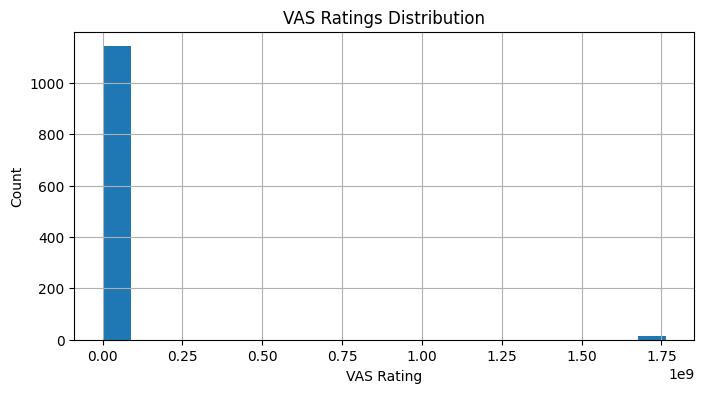

In [5]:
# Calculate statistical metrics and plot histogram
vas_col = vas_df.columns[0]  # Assume first column is VAS
print('VAS mean:', vas_df[vas_col].mean())
print('VAS median:', vas_df[vas_col].median())
print('VAS min/max:', vas_df[vas_col].min(), vas_df[vas_col].max())
plt.figure(figsize=(8,4))
vas_df[vas_col].hist(bins=20)
plt.title('VAS Ratings Distribution')
plt.xlabel('VAS Rating')
plt.ylabel('Count')
plt.show()

## 4. Grouping and Comparison by Condition
Compare VAS ratings by session, condition, or other variables if available.

In [6]:
# Example: Grouping by file (session)
vas_df['Session'] = vas_df['file'].apply(lambda x: x.split('/')[-1].split('_')[0])
session_stats = vas_df.groupby('Session')[vas_col].agg(['mean','median','std','count'])
print('VAS ratings by session:')
print(session_stats)

VAS ratings by session:
                 mean  median           std  count
Session                                           
Data\01  1.985537e+07    79.0  1.861769e+08   1155


## 5. Export and Visualization
Export the summarized VAS ratings and show further visualizations.

✓ Session statistics exported as CSV.


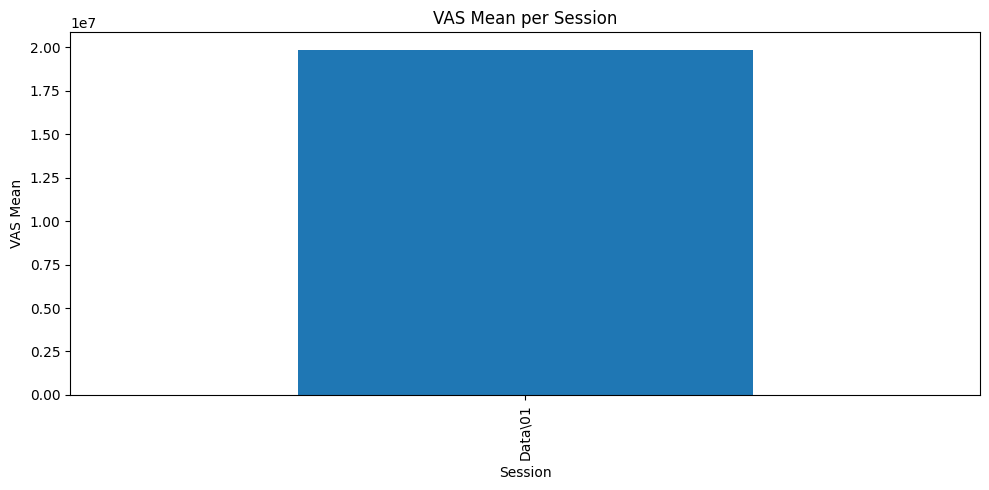

In [7]:
# Export session statistics as CSV
session_stats.to_csv('./results/vas_session_stats.csv')
print('✓ Session statistics exported as CSV.')
plt.figure(figsize=(10,5))
session_stats['mean'].plot(kind='bar')
plt.title('VAS Mean per Session')
plt.xlabel('Session')
plt.ylabel('VAS Mean')
plt.tight_layout()
plt.show()

## 6. VAS Ratings vs Predefined Alignment Conditions
Analyze how well participants' VAS ratings align with the experimentally defined alignment conditions (High/Medium/Low).

In [11]:
# Load VAS ratings with alignment conditions from CSV files (OPTIMIZED)
csv_files = glob.glob('./Data/*.csv')
print(f'Found {len(csv_files)} CSV files. Loading alignment and VAS data...')
all_ratings = []

for i, file in enumerate(csv_files):
    if (i + 1) % 10 == 0:
        print(f'  Processing file {i+1}/{len(csv_files)}...')
    
    try:
        # Only load the 2 columns we need (much faster than loading all 80+ columns)
        df = pd.read_csv(file, encoding='utf-8', usecols=['Alignment', 'slider.response'], on_bad_lines='skip')
        
        # Extract trial-level data
        trial_data = df.dropna()
        if len(trial_data) > 0:
            trial_data['file'] = file
            all_ratings.append(trial_data)
    except (ValueError, KeyError):
        # File doesn't have these columns, skip it
        continue
    except Exception as e:
        print(f'  Warning: Could not process {file}: {e}')
        continue

# Combine all ratings
if len(all_ratings) > 0:
    ratings_df = pd.concat(all_ratings, ignore_index=True)
    
    # Filter out invalid alignment values (test runs, incomplete trials)
    valid_alignments = ['high', 'medium', 'low', 'High', 'Medium', 'Low']
    ratings_df = ratings_df[ratings_df['Alignment'].isin(valid_alignments)]
    
    # Map alignment to expected VAS ranges
    # Assuming VAS scale is 0-100:
    # High alignment → should be rated high (e.g., 66-100)
    # Medium alignment → should be rated medium (e.g., 33-66)
    # Low alignment → should be rated low (e.g., 0-33)
    
    print(f'\n✓ Total trials with VAS ratings and alignment: {len(ratings_df)}')
    print(f'\nAlignment distribution:')
    print(ratings_df['Alignment'].value_counts())
    print(f'\nVAS rating statistics by alignment condition:')
    alignment_stats = ratings_df.groupby('Alignment')['slider.response'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    print(alignment_stats)
else:
    print('No data found with both Alignment and slider.response columns')

Found 141 CSV files. Loading alignment and VAS data...
  Processing file 10/141...
  Processing file 20/141...
  Processing file 30/141...
  Processing file 40/141...
  Processing file 50/141...
  Processing file 60/141...
  Processing file 70/141...
  Processing file 80/141...
  Processing file 90/141...
  Processing file 100/141...
  Processing file 110/141...


C:\Users\kimbe\AppData\Local\Temp\ipykernel_26248\3802331215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_data['file'] = file
C:\Users\kimbe\AppData\Local\Temp\ipykernel_26248\3802331215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_data['file'] = file
C:\Users\kimbe\AppData\Local\Temp\ipykernel_26248\3802331215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

  Processing file 120/141...
  Processing file 130/141...
  Processing file 140/141...

✓ Total trials with VAS ratings and alignment: 1154

Alignment distribution:
Alignment
high      396
medium    390
low       368
Name: count, dtype: int64

VAS rating statistics by alignment condition:
           count       mean  median        std  min    max
Alignment                                                 
high         396  94.118687   100.0  11.709287  3.0  100.0
low          368  53.687500    63.0  33.353080  0.0  100.0
medium       390  60.505128    70.0  31.161388  0.0  100.0


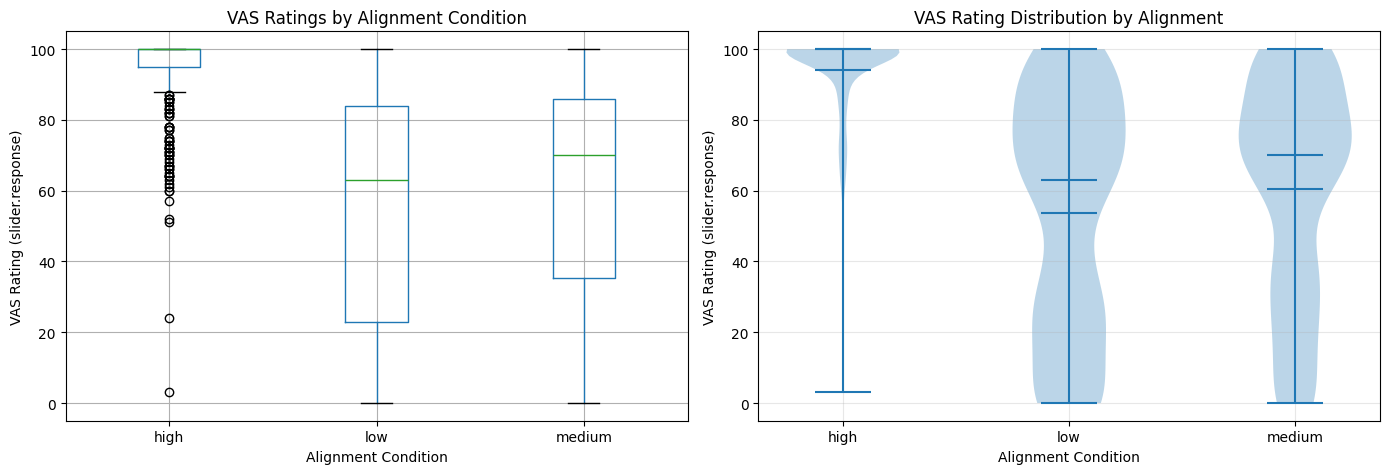

✓ Visualization saved: ./figures/vas_ratings_by_alignment.png


In [12]:
# Visualize VAS ratings by alignment condition
if len(all_ratings) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    ratings_df.boxplot(column='slider.response', by='Alignment', ax=axes[0])
    axes[0].set_title('VAS Ratings by Alignment Condition')
    axes[0].set_xlabel('Alignment Condition')
    axes[0].set_ylabel('VAS Rating (slider.response)')
    axes[0].get_figure().suptitle('')  # Remove automatic title
    
    # Violin plot for distribution
    alignment_groups = ratings_df.groupby('Alignment')['slider.response']
    positions = []
    data_to_plot = []
    labels = []
    
    for i, (alignment, group) in enumerate(alignment_groups):
        positions.append(i)
        data_to_plot.append(group.values)
        labels.append(alignment)
    
    parts = axes[1].violinplot(data_to_plot, positions=positions, showmeans=True, showmedians=True)
    axes[1].set_xticks(positions)
    axes[1].set_xticklabels(labels)
    axes[1].set_xlabel('Alignment Condition')
    axes[1].set_ylabel('VAS Rating (slider.response)')
    axes[1].set_title('VAS Rating Distribution by Alignment')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./figures/vas_ratings_by_alignment.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print('✓ Visualization saved: ./figures/vas_ratings_by_alignment.png')

In [13]:
# Calculate "accuracy" - how well VAS ratings match expected ranges
# Define expected ranges (assuming 0-100 scale, adjust if different)
def classify_vas_rating(rating):
    """Classify VAS rating into Low/Medium/High based on tertiles"""
    if rating <= 33.33:
        return 'low'
    elif rating <= 66.67:
        return 'medium'
    else:
        return 'high'

if len(all_ratings) > 0:
    # Normalize alignment labels to lowercase for comparison
    ratings_df['alignment_normalized'] = ratings_df['Alignment'].str.lower()
    ratings_df['vas_category'] = ratings_df['slider.response'].apply(classify_vas_rating)
    
    # Calculate agreement
    ratings_df['agreement'] = ratings_df['alignment_normalized'] == ratings_df['vas_category']
    
    # Overall accuracy
    accuracy = ratings_df['agreement'].mean() * 100
    print(f'\n{"="*60}')
    print(f'VAS RATING ACCURACY ANALYSIS')
    print(f'{"="*60}')
    print(f'\nOverall accuracy: {accuracy:.2f}%')
    print(f'Total agreements: {ratings_df["agreement"].sum()} / {len(ratings_df)}')
    
    # Confusion matrix
    print(f'\n{"="*60}')
    print('CONFUSION MATRIX: Predefined Alignment vs VAS Rating Category')
    print(f'{"="*60}')
    confusion = pd.crosstab(ratings_df['alignment_normalized'], 
                           ratings_df['vas_category'], 
                           margins=True, 
                           margins_name='Total')
    print(confusion)
    
    # Accuracy by condition
    print(f'\n{"="*60}')
    print('ACCURACY BY ALIGNMENT CONDITION')
    print(f'{"="*60}')
    condition_accuracy = ratings_df.groupby('alignment_normalized')['agreement'].agg(['sum', 'count', 'mean'])
    condition_accuracy['accuracy_%'] = condition_accuracy['mean'] * 100
    condition_accuracy.columns = ['Correct', 'Total', 'Proportion', 'Accuracy (%)']
    print(condition_accuracy)
    
    # Statistical test: Are VAS ratings significantly different between conditions?
    from scipy import stats
    
    high_ratings = ratings_df[ratings_df['alignment_normalized'] == 'high']['slider.response']
    medium_ratings = ratings_df[ratings_df['alignment_normalized'] == 'medium']['slider.response']
    low_ratings = ratings_df[ratings_df['alignment_normalized'] == 'low']['slider.response']
    
    # Kruskal-Wallis test (non-parametric ANOVA)
    h_stat, p_value = stats.kruskal(high_ratings, medium_ratings, low_ratings)
    
    print(f'\n{"="*60}')
    print('STATISTICAL TEST: Kruskal-Wallis H-test')
    print(f'{"="*60}')
    print(f'H-statistic: {h_stat:.4f}')
    print(f'p-value: {p_value:.6f}')
    if p_value < 0.001:
        print('Result: VAS ratings are SIGNIFICANTLY different between alignment conditions (p < 0.001) ***')
    elif p_value < 0.01:
        print('Result: VAS ratings are SIGNIFICANTLY different between alignment conditions (p < 0.01) **')
    elif p_value < 0.05:
        print('Result: VAS ratings are SIGNIFICANTLY different between alignment conditions (p < 0.05) *')
    else:
        print('Result: No significant difference between alignment conditions (p >= 0.05)')
    
    print(f'\n{"="*60}')


VAS RATING ACCURACY ANALYSIS

Overall accuracy: 50.95%
Total agreements: 588 / 1154

CONFUSION MATRIX: Predefined Alignment vs VAS Rating Category
vas_category          high  low  medium  Total
alignment_normalized                          
high                   379    2      15    396
low                    169  126      73    368
medium                 215   92      83    390
Total                  763  220     171   1154

ACCURACY BY ALIGNMENT CONDITION
                      Correct  Total  Proportion  Accuracy (%)
alignment_normalized                                          
high                      379    396    0.957071     95.707071
low                       126    368    0.342391     34.239130
medium                     83    390    0.212821     21.282051

STATISTICAL TEST: Kruskal-Wallis H-test
H-statistic: 470.4130
p-value: 0.000000
Result: VAS ratings are SIGNIFICANTLY different between alignment conditions (p < 0.001) ***


STATISTICAL TEST: Kruskal-Wallis H-test
H-stat

## 7. VAS Response Time Analysis
Analyze how long participants took to rate alignment on the VAS scale, broken down by alignment condition.